In [1]:
import os
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
from db.models import DB_FILE, TableName
from db.db import init_db, read_table
from db.migrations import run_all_migrations

This EDA will largely replicate the work done on the LP and GP dataset. Since LP data is the primary focus for this project, the work here will provide context to potential stretch goals that aim to include the entire dataset. 

# Initial EDA on raw data
As before, we will do a quick sanity check and exploration of the raw data as it is given. We will assume that the other two notebooks, or the entire cleaning pipeline have been run.

In [2]:
# Initialise SQL database
init_db()

Tables created successfully.


Now we can load the data back into a DataFrame and do some quick checks.

In [3]:
# Load into data frames
lp_data = read_table(TableName.LP)
gp_data = read_table(TableName.GP)
# Concatenate datasets
combined_df = pd.concat([lp_data, gp_data], ignore_index=True)
# Print first 5 rows
combined_df.head()

Read LP table from database!
Read GP table from database!


,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
0,155963,Noah Rawlings,Family Office - Single,None,1833,None,Board of Directors,President,GEN,None,...,WY,US,82001,None,North America,2020 Carey Avenue Suite 314,https://www.1833enterprises.com/,None,LP Contact Data,2025-06-19 00:11:50.216463
1,155962,Stephen Smith,Wealth Manager,Mr.,Smith Financial Corporation,None,"Board of Directors,Investment Team",Founder and Chief Executive Officer,GEN,None,...,None,Canada,None,www.linkedin.com/in/stephen-smith-aa71a71b6/,North America,,https://www.smithfc.ca/,info@smithfc.ca,LP Contact Data,2025-06-19 00:11:50.216463
2,155961,Joonas Huttunen,Investment Company,Mr.,Rake Development Company Oy,None,Investment Team,Chief Investment Officer,"PE,RE",None,...,None,Finland,00120,www.linkedin.com/in/joonas-huttunen/,Europe,"Bulevardi 6 B, 3krs.",https://rake.fi/en/etusivu,None,LP Contact Data,2025-06-19 00:11:50.216463
3,155960,Sijia Wang,Family Office - Multi,Mr.,Oshen,None,None,Managing Partner,"PE,INF",None,...,None,Luxembourg,1471,www.linkedin.com/in/peter-sijia-wang/,Europe,"270, route d'Esch",https://oshenbio.com/,info@oshenbio.com,LP Contact Data,2025-06-19 00:11:50.216463
4,155959,Didier Cowling,Family Office - Multi,Mr.,Oshen,None,None,Managing Partner,"PE,INF",None,...,None,Luxembourg,1471,www.linkedin.com/in/lifesciencesexpert/,Europe,"270, route d'Esch",https://oshenbio.com/,info@oshenbio.com,LP Contact Data,2025-06-19 00:11:50.216463


Lets take a look at the shape and data types.

In [4]:
combined_df.shape

(423417, 22)

Looks good. Lets inspect missing values. We'll do this by calculating the percentage of missing values for each column and plot the percentages as a bar graph.

<Axes: >

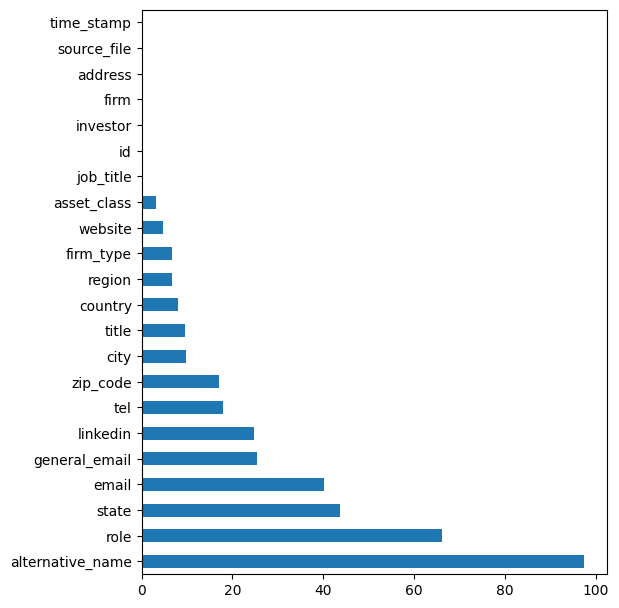

In [5]:
# Find % of missing values per column
missing_pct = combined_df.isna().mean().mul(100).sort_values(ascending=False)

# Quick bar chart to visualise
missing_pct.plot.barh(figsize=(6, max(3, len(missing_pct) / 3)))

Looks largely the same as our LP and GP data distribution for key fields.

In [6]:
# Numeric stats: count, mean, etc
combined_df.describe()

,id,time_stamp
count,423417.000000,423417
mean,113193.994221,2025-06-19 00:12:48.278068480
min,1.000000,2025-06-19 00:11:50.216463
25%,52928.000000,2025-06-19 00:11:50.216463104
50%,105855.000000,2025-06-19 00:13:22.136084992
75%,161600.000000,2025-06-19 00:13:22.136084992
max,267454.000000,2025-06-19 00:13:22.136085
std,72353.085564,NaN


Only two numeric columns so this is to be expected since ID is auto-incremented and timestamp is the same for all rows.

In [7]:
# Categorical/text: count, unique, etc
print(combined_df.describe(include="object"))

              investor            firm_type   title  \
count           423417               395534  383386   
unique          333634                   59      19   
top     Michael Miller  Private Equity Firm     Mr.   
freq                32               123818  295615   

                                          firm alternative_name  \
count                                   423417            10620   
unique                                   62673             9771   
top     Jones Day Defined Benefit Master Trust   Monty Cleworth   
freq                                      1769               10   

                   role job_title asset_class                         email  \
count            143815    423064      409651                        253559   
unique              288    103773         664                        229753   
top     Investment Team   Partner          PE  mmiller@crewcialpartners.com   
freq              72284     23455      101530                           

Largely a combination of what we have seen before. Interesting to note, 32 entries of Michael Miller, Jones Day Defined Benefit Master Trust appears a  lot. Theres an email that shows up 12 times, definitely a duplicate and will be picked up by our deduplication work.

Lets highlight unique fields specifically to further illustrate the point. 

In [8]:
# Iterate each column and check there unique and highest repeated values.
for col in combined_df.select_dtypes(include="object").columns:
    print(col, "->", combined_df[col].nunique(), "uniques")
    print(combined_df[col].value_counts().head(5))
    print("---")

investor -> 333634 uniques
investor
Michael Miller    32
Michael Smith     32
David Lee         30
Wei Wang          30
David Smith       29
Name: count, dtype: int64
---
firm_type -> 59 uniques
firm_type
Private Equity Firm            123818
Fund Manager                    52498
Wealth Manager                  47358
Hedge Fund Manager              39255
Private Sector Pension Fund     14918
Name: count, dtype: int64
---
title -> 19 uniques
title
Mr.     295615
Ms       71234
Dr.       7176
Ms.       5360
Miss      2137
Name: count, dtype: int64
---
firm -> 62673 uniques
firm
Jones Day Defined Benefit Master Trust            1769
Cerity Partners                                   1138
Ares Management                                    979
Weil, Gotshal & Manges Pension Fund                954
Retirement Plan for Non Legal Employees of STB     861
Name: count, dtype: int64
---
alternative_name -> 9771 uniques
alternative_name
Monty Cleworth    10
Jeannie Justie     9
刘伟                 8

Let's see if there is any corelation for missing columns and rows.

In [9]:
# Compute pairwise missingness
miss_gp = combined_df.isna().astype(int)
corr_gp = miss_gp.corr()
corr_gp["email"].sort_values(ascending=False)

email               1.000000
website             0.138894
general_email       0.100384
linkedin            0.054837
title               0.035872
job_title           0.000399
tel                -0.016604
state              -0.021305
zip_code           -0.043835
role               -0.095459
alternative_name   -0.122909
asset_class        -0.143300
city               -0.160846
country            -0.189999
region             -0.206377
firm_type          -0.208121
id                       NaN
investor                 NaN
firm                     NaN
address                  NaN
source_file              NaN
time_stamp               NaN
Name: email, dtype: float64

Same as with LP records, now its time to investigate duplicates.

In [10]:
# Extract duplicates
dupes_gp = combined_df.duplicated(subset=["investor", "firm"]).sum()
dupes_gp

np.int64(35603)

In [11]:
dup_mask_all = combined_df.duplicated(subset=["investor", "firm"], keep=False)
dupe_rows_all = combined_df[dup_mask_all].sort_values("investor")
dupe_rows_all.head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
121528,34435,'douard Leurent,Private Equity Fund of Funds Manager,None,Opale Capital,None,"Investment Team,Legal,Operations",Deputy Director General,PE,None,...,None,France,75008,www.linkedin.com/in/edouardleurent/,Europe,"32, rue de Monceau",https://opalecapital.com/,contact@opalecapital.com,LP Contact Data,2025-06-19 00:11:50.216463
239736,183681,'douard Leurent,Private Equity Fund of Funds Manager,None,Opale Capital,None,None,Deputy Director General,PE,None,...,None,France,75008,www.linkedin.com/in/edouardleurent/,Europe,"32, rue de Monceau",https://opalecapital.com/,contact@opalecapital.com,GP Contact Data,2025-06-19 00:13:22.136085
289072,134345,'ystein Wikan,Private Equity Firm,Mr.,Investinor,None,None,Investment Manager,"PE,VC",oystein.wikan@investinor.no,...,None,Norway,7010,linkedin.com/in/oysteinwikan,Europe,Brattørkaia 17B,http://www.investinor.no,post@investinor.no,GP Contact Data,2025-06-19 00:13:22.136085
64288,91675,'ystein Wikan,Asset Manager,Mr.,Investinor,None,Investment Team,Investment Manager,"PE,INF,NR",oystein.wikan@investinor.no,...,None,Norway,7010,www.linkedin.com/in/oysteinwikan/,Europe,Brattørkaia 17B,https://investinor.no/en/,post@investinor.no,LP Contact Data,2025-06-19 00:11:50.216463
397684,25733,? Wei,Fund Manager,Ms,Ares Management,None,None,Managing Director,"PE,VC",sui@aresmgmt.com,...,None,China,200040,www.linkedin.com/in/%E7%82%9C-nina-wei-%E9%9A%...,North America,1800 Avenue of the Stars Suite 1400,https://www.aresmgmt.com/,irares@aresmgmt.com,GP Contact Data,2025-06-19 00:13:22.136085
155289,674,? Wei,Fund Manager,Ms,Ares Management,隋炜,Investment Team,Managing Director,PE,sui@aresmgmt.com,...,None,US,200040,www.linkedin.com/in/%E7%82%9C-nina-wei-%E9%9A%...,North America,1800 Avenue of the Stars Suite 1400,https://www.aresmgmt.com/,irares@aresmgmt.com,LP Contact Data,2025-06-19 00:11:50.216463
71428,84535,A Acuff,Fund of Hedge Funds Manager,Mr.,Silvercrest Asset Management Group,None,"Board of Directors,Investment Team",Managing Director & Member of Investment Polic...,HF,macuff@silvercrestgroup.com,...,NY,US,10019,www.linkedin.com/in/acuff-marshall-46727a140/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-19 00:11:50.216463
140582,15381,A Acuff,Asset Manager,Mr.,Silvercrest Asset Management Group,None,"Board of Directors,Investment Team,Operations,...","Managing Director, Portfolio Manager","PE,RE,HF,PD,NR",macuff@silvercrestgroup.com,...,VA,US,23235,www.linkedin.com/in/acuff-marshall-46727a140/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-19 00:11:50.216463
201254,222163,A Acuff,Fund of Hedge Funds Manager,Mr.,Silvercrest Asset Management Group,None,None,Managing Director & Member of Investment Polic...,HF,macuff@silvercrestgroup.com,...,NY,US,10019,www.linkedin.com/in/acuff-marshall-46727a140/,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,GP Contact Data,2025-06-19 00:13:22.136085
187041,236376,A Dalal,Investment Company,Mr.,Tata Investment Corporation,None,None,Executive Director and Board of Directors,"PE,RE,INF,PD,NR",adalal@tata.com,...,Maharashtra,India,400001,www.linkedin.com/in/amit-n-dalal-a1377a6/,Asia,"Elphinstone Building, 2nd Floor 10 Veer Narima...",https://tatainvestment.com/,ticl@tata.com,GP Contact Data,2025-06-19 00:13:22.136085


We can infer from the top of the duplicates that alot of them are from the same person but working different roles within the company, likely from internal promotions. It would be interesting to see the fields which are still duplicate in `investor` and `firm` but not in `linkedin`.

In [12]:
# Filter duplicates by unique LinkedIns
link_nunique = dupe_rows_all.groupby(["investor", "firm"])["linkedin"].transform(
    lambda s: s.nunique(dropna=True)
)

# Keep only the rows where there’s more than one distinct LinkedIn
mismatch = dupe_rows_all[link_nunique > 1]

# Filter investor names that only appear once
name_counts = mismatch["investor"].value_counts()
keep_names = name_counts[name_counts > 1].index
final = mismatch[mismatch["investor"].isin(keep_names)]

final.sort_values(["investor", "firm"]).head(20)

,id,investor,firm_type,title,firm,alternative_name,role,job_title,asset_class,email,...,state,country,zip_code,linkedin,region,address,website,general_email,source_file,time_stamp
289072,134345,'ystein Wikan,Private Equity Firm,Mr.,Investinor,None,None,Investment Manager,"PE,VC",oystein.wikan@investinor.no,...,None,Norway,7010,linkedin.com/in/oysteinwikan,Europe,Brattørkaia 17B,http://www.investinor.no,post@investinor.no,GP Contact Data,2025-06-19 00:13:22.136085
64288,91675,'ystein Wikan,Asset Manager,Mr.,Investinor,None,Investment Team,Investment Manager,"PE,INF,NR",oystein.wikan@investinor.no,...,None,Norway,7010,www.linkedin.com/in/oysteinwikan/,Europe,Brattørkaia 17B,https://investinor.no/en/,post@investinor.no,LP Contact Data,2025-06-19 00:11:50.216463
14945,141018,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,"Investment Team,Operations","Co-Founder, Partner & Director of Equity Resea...",GEN,aammerman@alphaky.com,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman-92358323/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-19 00:11:50.216463
14948,141015,Aaron Ammerman,Wealth Manager,Mr.,Alpha Financial Partners,None,Investment Team,"Co-Founder, Partner",GEN,None,...,KY,US,40508,www.linkedin.com/in/aaron-ammerman/,North America,319 Cedar Street Suite 201,https://www.alphaky.com/,info@alphaky.com,LP Contact Data,2025-06-19 00:11:50.216463
128625,27338,Aaron Kowal,Wealth Manager,Mr.,Creative Planning,None,"Board of Directors,Investment Team","Partner,Managing Director","PE,RE,INF,PD",None,...,FL,US,33904,www.linkedin.com/in/aaronkowal/,North America,5454 West 110th Street,https://creativeplanning.com/,cpi@creativeplanning.com,LP Contact Data,2025-06-19 00:11:50.216463
128244,27719,Aaron Kowal,Wealth Manager,Mr.,Creative Planning,None,Board of Directors,Partner/Managing Director,"PE,RE,INF,PD",None,...,KS,US,66211,www.linkedin.com/in/aaronkowal /,North America,5454 West 110th Street,https://creativeplanning.com/,cpi@creativeplanning.com,LP Contact Data,2025-06-19 00:11:50.216463
50828,105135,Aaron Waxman,Fund of Hedge Funds Manager,Mr.,Cerity Partners,None,Investment Team,Partner,HF,awaxman@ceritypartners.com,...,CA,US,94104,www.linkedin.com/in/aaron-waxman-cpa-cfp®-4aa3...,North America,99 Park Avenue,https://ceritypartners.com/,None,LP Contact Data,2025-06-19 00:11:50.216463
130952,25011,Aaron Waxman,Wealth Manager,Mr.,Cerity Partners,None,"Finance/Accountancy,Investment Team",Partner,"PE,RE,INF,HF,PD,NR",None,...,CA,US,94104,www.linkedin.com/in/aaron-waxman-cpa-cfp%C2%AE...,North America,99 Park Avenue 16th Floor,https://ceritypartners.com,privacy@ceritypartners.com,LP Contact Data,2025-06-19 00:11:50.216463
363511,59906,Aaron Waxman,Fund of Hedge Funds Manager,Mr.,Cerity Partners,None,None,Partner,HF,awaxman@ceritypartners.com,...,CA,US,94104,www.linkedin.com/in/aaron-waxman-cpa-cfp®-4aa3...,North America,99 Park Avenue,https://ceritypartners.com/,None,GP Contact Data,2025-06-19 00:13:22.136085
71430,84533,Adam Dahms,Fund of Hedge Funds Manager,Mr.,Silvercrest Asset Management Group,None,Investment Team,Vice President & Senior Equity Analyst,HF,adahms@silvercrestgroup.com,...,WI,US,53202,linkedin.com/in/afdahms,North America,1330 Avenue of the Americas 38th Floor,http://www.silvercrestgroup.com,info@silvercrestgroup.com,LP Contact Data,2025-06-19 00:11:50.216463


This seems like a good way to prove true duplicates, it will come in useful when we begin cleaning. Let's do some email domain analysis to get an idea of what our data looks like.

In [13]:
# Normalise, split into email doamin and group into pairs
df_pairs = (
    combined_df[["firm", "email"]]
    .dropna(subset=["email"])
    .assign(
        domain=lambda d: d["email"].str.split("@").str[-1].str.lower(),
        firm=lambda d: d["firm"].str.lower(),
    )
    .loc[:, ["domain", "firm"]]
)

# Drop duplicates and print
df_unique = df_pairs.drop_duplicates()
df_unique.to_numpy().tolist()

[['albainvestments.ch', 'alba investment partners'],
 ['fondrenoakscapital.com', 'fondren oaks capital management'],
 ['rysecapitalmanagement.com', 'ryse capital management'],
 ['coronadoadvisors.com', 'coronado financial group'],
 ['nicolfinancial.com', 'nicol financial services'],
 ['bluecapitalwealth.com', 'blue capital'],
 ['mcdonnaugh.com', 'ai mcdonnaugh & co.'],
 ['luesinkstenstrom.com', 'luesink stenstrom financial'],
 ['investedgeplanning.com', 'investedge planning'],
 ['myfirmllc.com', 'pursuit wealth management'],
 ['kdmwealth.com', 'kdm wealth management'],
 ['arrowstonewealth.com', 'arrowstone wealth'],
 ['farrautowealth.com', 'farrauto wealth management'],
 ['sunquestwm.com', 'sunquest wealth management'],
 ['berenzwealthmanagement.com', 'berenz wealth management'],
 ['nicholswealthadvisors.com', 'nichols wealth advisors'],
 ['goldmarkfp.com', 'goldmark financial planners'],
 ['celadonwealth.com', 'celadon managed wealth'],
 ['trubeewealth.com', 'trubee wealth advisors'],

They seem to be all firm name domains. To be sure it would be interesting to see which domains are used across different firms. 

In [14]:
# Count how many distinct firms per domain
domain_firm_counts = df_pairs.groupby("domain")["firm"].nunique()


# Only keep domains where span is larger than 1
multi_firm = domain_firm_counts[domain_firm_counts > 1]

print(multi_firm.shape)
multi_firm.sort_values(ascending=False).to_dict()

(4051,)


{'gmail.com': 142,
 'nepc.com': 46,
 'meketa.com': 41,
 'cambridgeassociates.com': 35,
 'marquetteassociates.com': 30,
 'lpl.com': 29,
 'callan.com': 28,
 'andcoconsulting.com': 27,
 'feg.com': 26,
 'mercer.com': 26,
 'segalmarco.com': 24,
 'dahab.com': 23,
 'ubs.com': 23,
 'msgraystone.com': 21,
 'cvc.com': 21,
 'yahoo.com': 19,
 'qq.com': 18,
 'hotmail.com': 17,
 'morganstanley.com': 17,
 'monticelloassociates.com': 17,
 'primebuchholz.com': 16,
 'wilshire.com': 15,
 '163.com': 15,
 'samsung.com': 13,
 'acgnet.com': 13,
 'rvkinc.com': 12,
 'verusinvestments.com': 12,
 'raymondjames.com': 12,
 'crewcialpartners.com': 12,
 'aonhewitt.com': 11,
 'macquarie.com': 11,
 'meketagroup.com': 11,
 'tpg.com': 11,
 'hamiltonlane.com': 11,
 'stepstoneglobal.com': 10,
 '126.com': 10,
 'burgesschambers.com': 9,
 'cliffwater.com': 9,
 'truist.com': 9,
 'baincapital.com': 9,
 'db.com': 9,
 'aon.com': 9,
 'bnymellon.com': 9,
 'aol.com': 9,
 'sphp.com': 9,
 'bmo.com': 9,
 'gs.com': 8,
 'lcgassociates.c

So clearly gmail is generic email domain, probably an individual investor. Whereas other domains seem to be associated with either subtly misspelled firm names or different departments within the same firm.

The next thing to look at is string length distributions to see if we can identify any obvious outliers.

In [15]:
# Compute lengths for each column
length_df = pd.DataFrame(
    {
        "investor_len": combined_df["investor"].dropna().str.len(),
        "email_len": combined_df["email"].dropna().str.len(),
        "firm_len": combined_df["firm"].dropna().str.len(),
    }
)

# Show summary stats
length_df.describe().T

,count,mean,std,min,25%,50%,75%,max
investor_len,423417.0,13.037181,2.956966,1.0,11.0,13.0,15.0,57.0
email_len,253559.0,23.971908,5.576843,7.0,20.0,24.0,28.0,62.0
firm_len,423417.0,20.478670,9.713500,1.0,14.0,19.0,25.0,100.0


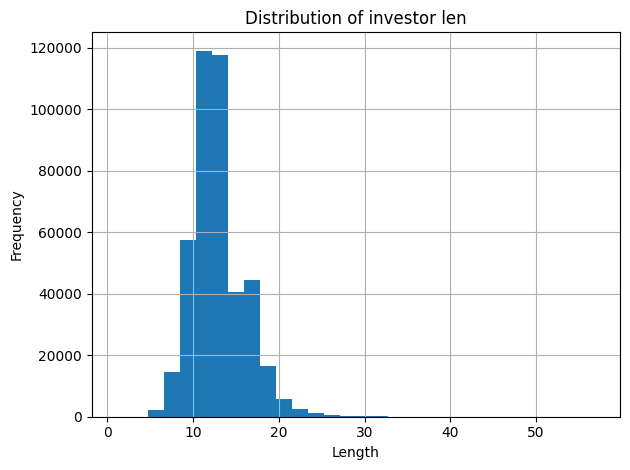

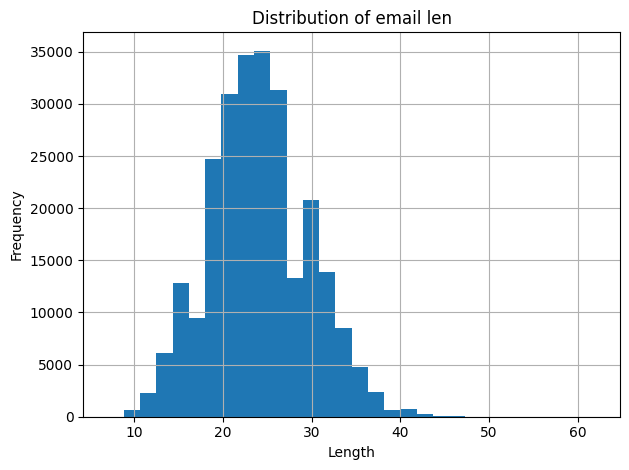

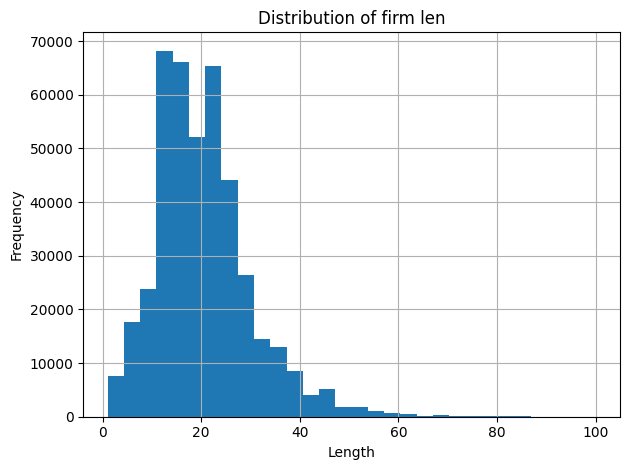

In [16]:
# Plot each distribution
for col in ["investor_len", "email_len", "firm_len"]:
    plt.figure()
    length_df[col].hist(bins=30)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

Very similar distributions to the LP dataset, we can use the same tools to clean and deduplicate.

This will inform the ranges we will use to flag anomalies for manual review.

# Initial Data Cleaning

Now that data cleaning functions have been defined, it is time to do some more EDA to see where we are at before we move onto imputation. We should focus on which fields are missing and which are recoverable. Ultimately the ML model will take investor name and firm name pairs as inputs, so other fields may not be important. However, our initial EDA discovered a lot of missing emails. We'll start by reading the already clean data.

In [17]:
# Load into data frame
clean_combined = read_table(TableName.COMBINED_CLEAN)

Read COMBINED_CLEAN table from database!


Let's take a look at our missing values to see if we can better inform our imputation strategy. 

In [18]:
# Check null percentage per column
missing_summary = clean_combined.isnull().mean().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

alternative_name    0.990979
role                0.698986
state               0.438267
linkedin            0.218397
general_email       0.215181
tel                 0.173061
zip_code            0.172133
city                0.123408
country             0.110327
region              0.096987
firm_type           0.096170
title               0.087757
asset_class         0.048319
website             0.022956
job_title           0.000632
dtype: float64


Fields like `state`, `city`, `zip_code`, `region`, `title` and `role` could be useful for filtering duplicates and have relatively low missing rates. These fields could reasonably inferred from the firm name. 

The priority here is clearly the `email` is the priority, potentially we could fallback to general email or even the LinkedIn profile. Lets see how often `email`, `linkedin` and `general_email` are missing together.

In [19]:
# Check email and general email missingness
email_missing_general_present = (
    clean_combined["email"].isnull() & clean_combined["general_email"].notnull()
)
email_present_general_missing = (
    clean_combined["email"].notnull() & clean_combined["general_email"].isnull()
)
both_missing = (
    clean_combined["email"].isnull() & clean_combined["general_email"].isnull()
)

# Check email and linkedin missingness
email_missing_linkedin_present = (
    clean_combined["email"].isnull() & clean_combined["linkedin"].notnull()
)
email_present_linkedin_missing = (
    clean_combined["email"].notnull() & clean_combined["linkedin"].isnull()
)
both_missing_linkedin = (
    clean_combined["email"].isnull() & clean_combined["linkedin"].isnull()
)

# Print summary counts
print("Email missing & General Email present:", email_missing_general_present.sum())
print("Email present & General Email missing:", email_present_general_missing.sum())
print("Both Email and General Email missing:", both_missing.sum())
print("Email missing & LinkedIn present:", email_missing_linkedin_present.sum())
print("Email present & LinkedIn missing:", email_present_linkedin_missing.sum())
print("Both Email and LinkedIn missing:", both_missing_linkedin.sum())

Email missing & General Email present: 0
Email present & General Email missing: 52456
Both Email and General Email missing: 0
Email missing & LinkedIn present: 0
Email present & LinkedIn missing: 53240
Both Email and LinkedIn missing: 0


So clearly there is oppurtunity to recover missing emails from LinkedIn and maybe even general email. Although using the general email as fallback could pollute the dataset as we miss out on the syntactic structure of first and last name in the email construction.

Lets see if there is any corelation between the missing values.

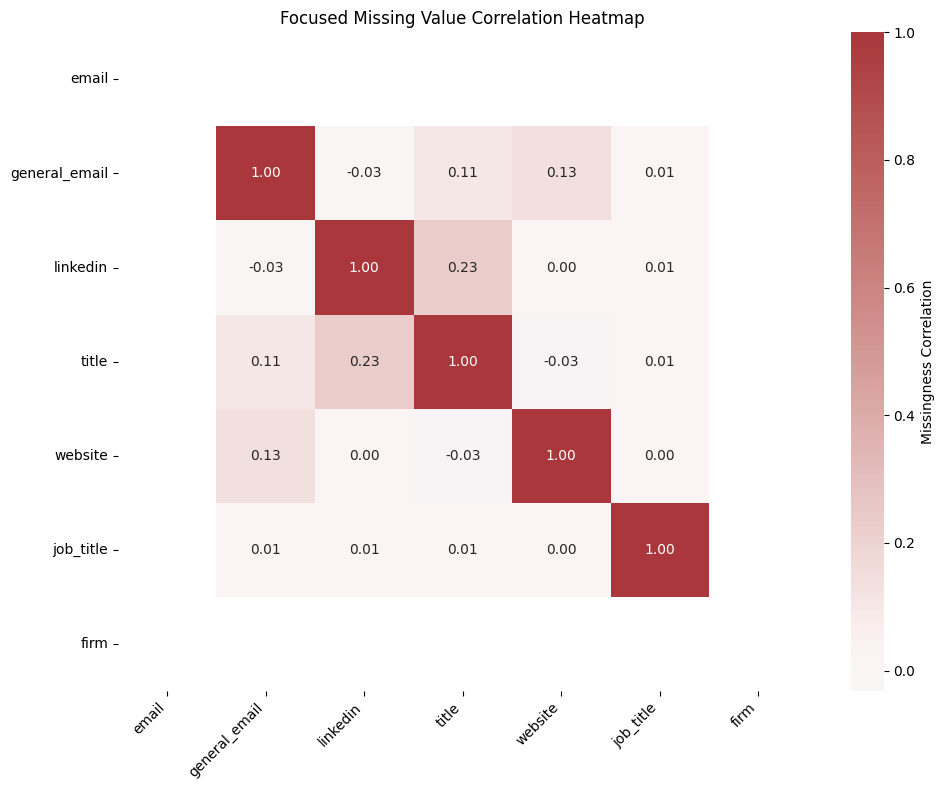

In [20]:
# Correlation between relevant fields
fields = ["email", "general_email", "linkedin", "title", "website", "job_title", "firm"]

# Filter and create massiness matrix
missing_corr = clean_combined[fields].isnull().astype(int).corr()

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    missing_corr,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    cbar_kws={"label": "Missingness Correlation"},
)
plt.title("Focused Missing Value Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

Similar to the LP case, there isn't much of a corelation in missingness. Will use same tactics as LP case for duplication and fallbacks.

Lets plot the firm and domain counts.

(20,)


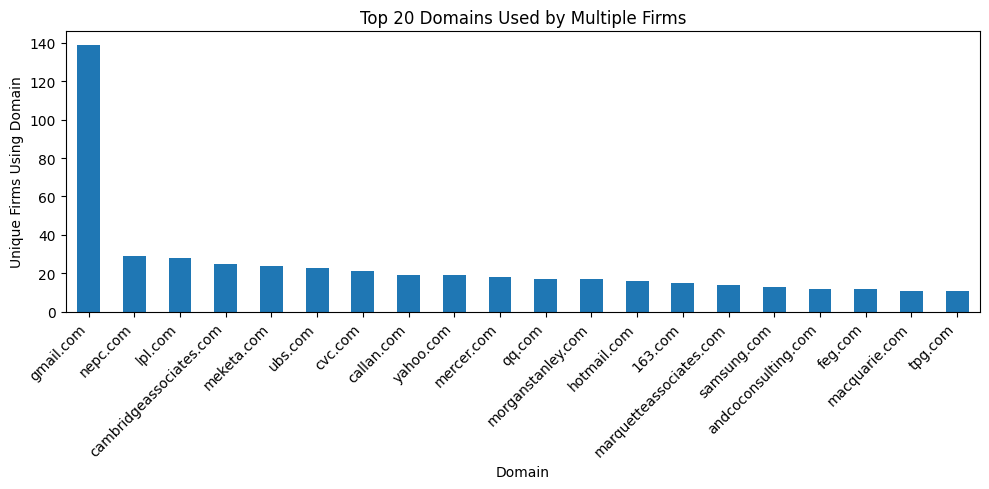

In [21]:
# Extract domain and count firms per domain
clean_combined["domain"] = clean_combined["email"].str.extract("@(.*)$")[0].str.lower()
domain_firm_counts = (
    clean_combined.groupby("domain")["firm"].nunique().sort_values(ascending=False)
)

# Filter to only domains used by >1 firm (for clarity)
shared_domains = domain_firm_counts[domain_firm_counts > 1].head(20)
print(shared_domains.shape)

plt.figure(figsize=(10, 5))
shared_domains.plot(kind="bar")
plt.title("Top 20 Domains Used by Multiple Firms")
plt.xlabel("Domain")
plt.ylabel("Unique Firms Using Domain")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Same as expected, we saw the same trends and investigated in previous notebooks. Since the data is already clean we will not repeat our selves as there is nothing left to learn. Lets take a look at the reverse count just for sureness.

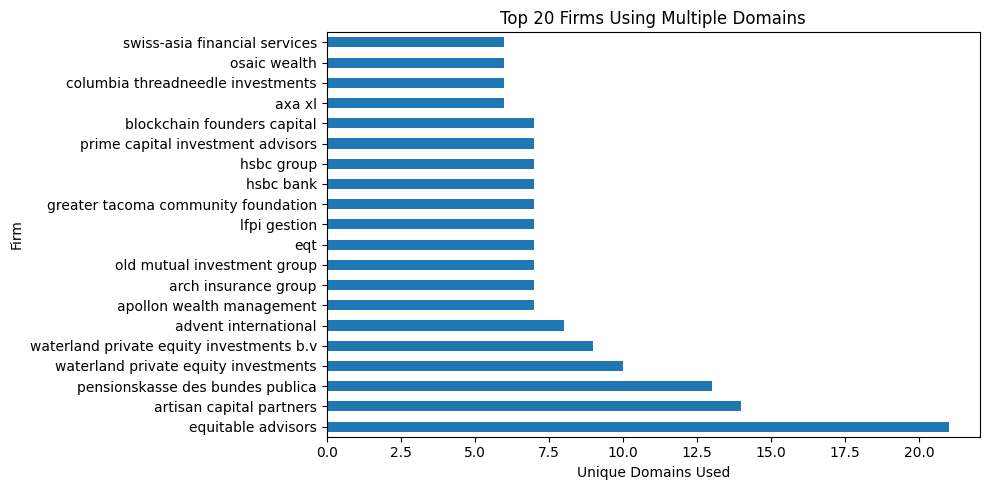

In [22]:
# Count domains per firm
firm_domain_counts = (
    clean_combined.groupby("firm")["domain"].nunique().sort_values(ascending=False)
)

# Filter to firms using >1 domain
multi_domain_firms = firm_domain_counts[firm_domain_counts > 1].head(20)

plt.figure(figsize=(10, 5))
multi_domain_firms.plot(kind="barh")
plt.title("Top 20 Firms Using Multiple Domains")
plt.xlabel("Unique Domains Used")
plt.ylabel("Firm")
plt.tight_layout()
plt.show()

Lets inspect our `firm` and `domain` cardinality. 

In [23]:
print("Unique firms:", clean_combined["firm"].nunique())
print("Unique domains:", clean_combined["domain"].nunique())
print("Top domains:\n", clean_combined["domain"].value_counts().head(10))
print("Top firms:\n", clean_combined["firm"].value_counts().head(10))

Unique firms: 41394
Unique domains: 41351
Top domains:
 domain
jonesday.com         1714
weil.com              938
stblaw.com            855
cooley.com            826
sidley.com            799
whitecase.com         748
aresmgmt.com          622
akingump.com          557
ropesgray.com         555
partnersgroup.com     544
Name: count, dtype: int64
Top firms:
 firm
jones day defined benefit master trust                  1714
weil, gotshal & manges pension fund                      938
retirement plan for non legal employees of stb           853
gc&h investments                                         826
sidley austin master pension trust                       800
white & case llp master retirement trust                 748
ares management                                          591
akin gump strauss hauer & feld llp master trust          556
ropes & gray llp supplemental retirement shares plan     556
kroll                                                    510
Name: count, dtype: int6

This concludes the Combined dataset EDA and EDA in general. Time for the pattern mining phase. See you in the template coverage notebook.